<a href="https://www.kaggle.com/code/thiagosalesfreireluz/random-forest-exoplanet?scriptVersionId=224345042" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics
from numpy import mean
from numpy import std
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import geneticalgorithmrf  #genetic algorithum module
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from numpy.random import seed
import time


In [2]:
data = pd.read_csv('../input/kepler-exoplanet-search-results/cumulative.csv')

In [3]:
# getting data
df = data

# Drop unused columns
df = df.drop(['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_score'], axis=1)
  
# Limit target values to CANDIDATE and CONFIRMED
false_positive_rows = df.query("koi_disposition == 'FALSE POSITIVE'").index
df = df.drop(false_positive_rows, axis=0).reset_index(drop=True)

#Transforming target column in binary data
df['koi_disposition'] = df['koi_disposition'].map({"CANDIDATE":1,"CONFIRMED":0})
    
# Drop columns with all missing values
df = df.drop(['koi_teq_err1', 'koi_teq_err2'], axis=1)

# Fill remaining missing values
df['koi_tce_delivname'] = df['koi_tce_delivname'].fillna(df['koi_tce_delivname'].mode()[0])
for column in df.columns[df.isna().sum() > 0]:
    df[column] = df[column].fillna(df[column].mean())



# One-hot encode koi_tce_delivname column
delivname_dummies = pd.get_dummies(df['koi_tce_delivname'], prefix='delivname')
df = pd.concat([df, delivname_dummies], axis=1)
df = df.drop('koi_tce_delivname', axis=1)

# Split df into X and y
y = df['koi_disposition']
X = df.drop('koi_disposition', axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
# Scale X
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
X_train, X_test, y_train, y_test


(      koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  koi_period  \
 1673      -0.071134      -0.117116        -0.0355      -0.017742   -0.037165   
 1239      -0.071134      -0.117116        -0.0355      -0.017742   -0.004275   
 3589      -0.071134      -0.117116        -0.0355      -0.017742    0.174458   
 415       -0.071134      -0.117116        -0.0355      -0.017742   -0.037962   
 2925      -0.071134      -0.117116        -0.0355      -0.017742    0.010035   
 ...             ...            ...            ...            ...         ...   
 2895      -0.071134      -0.117116        -0.0355      -0.017742   -0.035650   
 2763      -0.071134      -0.117116        -0.0355      -0.017742   -0.031798   
 905       -0.071134      -0.117116        -0.0355      -0.017742   -0.026434   
 3980      -0.071134      -0.117116        -0.0355      -0.017742   -0.034204   
 235       -0.071134      -0.117116        -0.0355      -0.017742   -0.037964   
 
       koi_period_err1  ko

In [4]:
#clf = RandomForestClassifier(n_estimators = 1600, criterion= 'entropy', max_features= 'sqrt', max_depth=None)
clf = RandomForestClassifier()

In [5]:
clf.fit(X_train,y_train)

RandomForestClassifier()

In [6]:
def get_classifications(y_test, y_pred, positive_label=1):
    tp = 0
    fn = 0
    fp = 0
    tn = 0
    
    for y_t, y_p in zip(y_test, y_pred):
        if y_t == positive_label:
            if y_p == positive_label:
                tp += 1
            else:
                fn += 1
        else:
            if y_p == positive_label:
                fp += 1
            else:
                tn += 1
    
    return tp, fn, fp, tn

def get_accuracy(tp, fn, fp, tn):
    acc = (tp + tn) / (tp + fn + fp + tn)
    return acc

def get_precision(tp, fn, fp, tn):
    precision = tp / (tp + fp)
    return precision

def get_recall(tp, fn, fp, tn):
    recall = tp / (tp + fn)
    return recall

def get_f1_score(tp, fn, fp, tn):
    precision = get_precision(tp, fn, fp, tn)
    recall = get_recall(tp, fn, fp, tn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def get_sensitivity(tp, fn, fp, tn):
    sensitivity = tp / (tp + fn)
    return sensitivity

def get_specificity(tp, fn, fp, tn):
    specificity = tn / (tn + fp)
    return specificity

In [7]:
seed(0)

In [8]:
#Measure time
start_time = time.time()

In [9]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.79120879 0.84581498 0.83039648 0.82599119 0.8215859  0.80837004
 0.83039648 0.83920705 0.81938326 0.79735683 0.82857143 0.8215859
 0.80176211 0.81718062 0.81938326 0.81938326 0.84361233 0.82378855
 0.83920705 0.80176211 0.82417582 0.83920705 0.83700441 0.80837004
 0.81938326 0.80176211 0.83039648 0.81497797 0.81718062 0.85903084
 0.83956044 0.81938326 0.82378855 0.83480176 0.81938326 0.84801762
 0.78634361 0.85903084 0.83480176 0.80176211 0.82637363 0.83039648
 0.83700441 0.81718062 0.78634361 0.82599119 0.84140969 0.83920705
 0.8061674  0.8061674 ]
Accuracy: 0.8232 (0.0168)


In [10]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, scoring='recall', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('sensitivity: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.73333333 0.83482143 0.77678571 0.83555556 0.81777778 0.78222222
 0.77777778 0.81777778 0.76       0.76444444 0.78666667 0.79464286
 0.75       0.83111111 0.82222222 0.78222222 0.8        0.80888889
 0.81777778 0.8        0.81333333 0.78571429 0.82589286 0.76
 0.8        0.75111111 0.8        0.82222222 0.8        0.86222222
 0.8        0.81696429 0.79910714 0.79555556 0.83111111 0.79555556
 0.73777778 0.8        0.83555556 0.77777778 0.80444444 0.75446429
 0.85714286 0.79555556 0.76888889 0.79555556 0.81333333 0.77333333
 0.79555556 0.78222222]
sensitivity: 0.7969 (0.0283)


In [11]:
specificity = make_scorer(recall_score, pos_label=0)

In [12]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, cv=cv, scoring = specificity, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('specificity: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.86086957 0.86521739 0.86086957 0.81222707 0.84716157 0.83406114
 0.87772926 0.86462882 0.88646288 0.79475983 0.84782609 0.84347826
 0.85652174 0.84279476 0.81222707 0.87772926 0.89956332 0.86462882
 0.83842795 0.79912664 0.83043478 0.87391304 0.83913043 0.84716157
 0.82969432 0.8558952  0.84716157 0.84716157 0.86026201 0.86899563
 0.86086957 0.83478261 0.86521739 0.87336245 0.79475983 0.87772926
 0.82969432 0.87336245 0.83406114 0.82969432 0.86956522 0.8826087
 0.82173913 0.86899563 0.81659389 0.87772926 0.83842795 0.87772926
 0.84716157 0.83406114]
specificity: 0.8499 (0.0243)


In [13]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('precision: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.825      0.84753363 0.84615385 0.83185841 0.8287037  0.80542986
 0.8647343  0.84331797 0.84390244 0.80373832 0.83333333 0.8372093
 0.84924623 0.83710407 0.81696429 0.85853659 0.87804878 0.85024155
 0.82882883 0.80357143 0.83486239 0.87192118 0.81497797 0.82439024
 0.8202765  0.82673267 0.86124402 0.81900452 0.8364486  0.86036036
 0.85714286 0.79646018 0.86057692 0.86057692 0.81385281 0.87684729
 0.80952381 0.85321101 0.83856502 0.81990521 0.85781991 0.86138614
 0.83842795 0.8490566  0.79723502 0.85238095 0.83035714 0.86893204
 0.82159624 0.82407407]
precision: 0.8378 (0.0211)


In [14]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('f1 score: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.784689   0.85333333 0.80645161 0.83150985 0.82460137 0.80973451
 0.8221709  0.83972912 0.80760095 0.78911565 0.80369515 0.82727273
 0.78873239 0.82432432 0.81596452 0.81018519 0.84259259 0.8156682
 0.83783784 0.79820628 0.83446712 0.81860465 0.83555556 0.78773585
 0.80637813 0.77283372 0.82837529 0.81715576 0.80637813 0.85462555
 0.82379863 0.81069042 0.8183908  0.82568807 0.81777778 0.8156682
 0.77674419 0.8440367  0.83482143 0.78555305 0.82134571 0.8221709
 0.8388521  0.81632653 0.7716895  0.83140878 0.83296214 0.82325581
 0.79818594 0.80725624]
f1 score: 0.8162 (0.0197)


In [15]:
#Print Time
print("--- %s seconds ---" % (time.time() - start_time))

--- 171.18770265579224 seconds ---


In [16]:
y_pred = clf.predict(X_test)
print(" Accuracy: {:.3f}%".format(get_accuracy(*get_classifications(y_test, y_pred)) * 100))

 Accuracy: 81.218%


In [17]:
y_pred = clf.predict(X_test)
print(" Sensitivity: {:.3f}%".format(get_sensitivity(*get_classifications(y_test, y_pred)) * 100))

 Sensitivity: 77.997%


In [18]:
y_pred = clf.predict(X_test)
print(" Specificity: {:.3f}%".format(get_specificity(*get_classifications(y_test, y_pred)) * 100))

 Specificity: 84.233%


In [19]:
y_pred = clf.predict(X_test)
print(" Precision: {:.3f}%".format(get_precision(*get_classifications(y_test, y_pred)) * 100))

 Precision: 82.240%


In [20]:
y_pred = clf.predict(X_test)
print(" F1 Score: {:.5f}".format(get_f1_score(*get_classifications(y_test, y_pred))))

 F1 Score: 0.80062


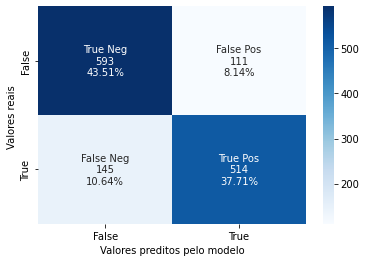

In [21]:
y_pred = clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('Valores preditos pelo modelo')
ax.set_ylabel('Valores reais ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.savefig('my_plot.JPEG')
plt.show()


In [22]:
"""numberOfParents = 8 #number of parents to start
numberOfParentsMating = 4 #number of parents that will mate
numberOfParameters = 2 #number of parameters that will be optimized
numberOfGenerations = 4 #number of genration that will be created
#define the population size


geneticalgorithmrf.printhello("hello world")

populationSize = (numberOfParents, numberOfParameters)
#initialize the population with randomly generated parameters
population = geneticalgorithmrf.initilialize_population(numberOfParents)
#define an array to store the fitness  history
fitnessHistory = np.empty([numberOfGenerations+1, numberOfParents])
#define an array to store the value of each parameter for each parent and generation
populationHistory = np.empty([(numberOfGenerations+1)*numberOfParents, numberOfParameters])

#insert the value of initial parameters in history
populationHistory[0:numberOfParents, :] = population
for generation in range(numberOfGenerations):
    print("This is number %s generation" % (generation))
    
    #train the dataset and obtain fitness
    fitnessValue = geneticalgorithmrf.train_population(population, X_train,  y_train, X_test, y_test)
    geneticalgorithmrf.printhello("hello world")
    fitnessHistory[generation, :] = fitnessValue
    
    #best score in the current iteration"""

'numberOfParents = 8 #number of parents to start\nnumberOfParentsMating = 4 #number of parents that will mate\nnumberOfParameters = 2 #number of parameters that will be optimized\nnumberOfGenerations = 4 #number of genration that will be created\n#define the population size\n\n\ngeneticalgorithmrf.printhello("hello world")\n\npopulationSize = (numberOfParents, numberOfParameters)\n#initialize the population with randomly generated parameters\npopulation = geneticalgorithmrf.initilialize_population(numberOfParents)\n#define an array to store the fitness  history\nfitnessHistory = np.empty([numberOfGenerations+1, numberOfParents])\n#define an array to store the value of each parameter for each parent and generation\npopulationHistory = np.empty([(numberOfGenerations+1)*numberOfParents, numberOfParameters])\n\n#insert the value of initial parameters in history\npopulationHistory[0:numberOfParents, :] = population\nfor generation in range(numberOfGenerations):\n    print("This is number %s

In [23]:
#Best solution from the final iteration

"""fitness = geneticalgorithmrf.train_population(population, X_train,  y_train, X_test, y_test)
fitnessHistory[generation+1, :] = fitness

#index of the best solution
bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]

#Best fitness
print("Best fitness is =", fitness[bestFitnessIndex])

#Best parameters
print("Best parameters are:")
print('learning_rate', population[bestFitnessIndex][0])
print('max_depth', population[bestFitnessIndex][1])
 



#visualize the change in fitness of the various generations and parents


geneticalgorithmrf.plot_parameters(numberOfGenerations, numberOfParents, fitnessHistory, "fitness (F1-score)")

#Look at individual parameters change with generation
#Create array for each parameter history (Genration x Parents)


nEstimatorHistory = populationHistory[:, 1].reshape([numberOfGenerations+1, numberOfParents])
maxdepthHistory = populationHistory[:, 1].reshape([numberOfGenerations+1, numberOfParents])



#generate heatmap for each parameter


geneticalgorithmrf.plot_parameters(numberOfGenerations, numberOfParents, nEstimatorHistory, "n_estimator")
geneticalgorithmrf.plot_parameters(numberOfGenerations, numberOfParents, maxdepthHistory, "maximum depth")"""

'fitness = geneticalgorithmrf.train_population(population, X_train,  y_train, X_test, y_test)\nfitnessHistory[generation+1, :] = fitness\n\n#index of the best solution\nbestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]\n\n#Best fitness\nprint("Best fitness is =", fitness[bestFitnessIndex])\n\n#Best parameters\nprint("Best parameters are:")\nprint(\'learning_rate\', population[bestFitnessIndex][0])\nprint(\'max_depth\', population[bestFitnessIndex][1])\n \n\n\n\n#visualize the change in fitness of the various generations and parents\n\n\ngeneticalgorithmrf.plot_parameters(numberOfGenerations, numberOfParents, fitnessHistory, "fitness (F1-score)")\n\n#Look at individual parameters change with generation\n#Create array for each parameter history (Genration x Parents)\n\n\nnEstimatorHistory = populationHistory[:, 1].reshape([numberOfGenerations+1, numberOfParents])\nmaxdepthHistory = populationHistory[:, 1].reshape([numberOfGenerations+1, numberOfParents])\n\n\n\n#generate heat

In [24]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(n_jobs=1)

In [25]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

koi_model_snr                0.118914
koi_duration_err2            0.077298
koi_duration_err1            0.054214
koi_time0bk_err2             0.052981
koi_time0bk_err1             0.050427
koi_duration                 0.046192
koi_prad                     0.028296
koi_impact                   0.028234
koi_steff_err2               0.027170
koi_prad_err1                0.025642
koi_period_err1              0.025579
koi_srad_err1                0.024807
koi_depth_err1               0.024692
koi_steff_err1               0.023962
koi_depth_err2               0.023904
koi_period_err2              0.023846
koi_prad_err2                0.022729
koi_impact_err1              0.021617
koi_period                   0.021063
koi_depth                    0.020824
koi_time0bk                  0.020187
ra                           0.019939
koi_kepmag                   0.018728
dec                          0.018694
koi_impact_err2              0.018616
koi_srad_err2                0.016650
koi_slogg_er

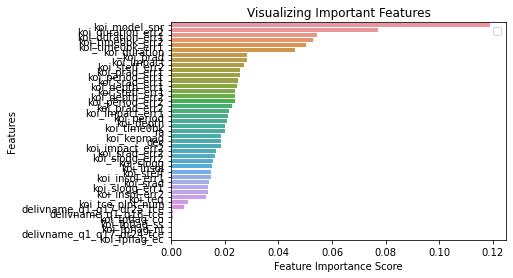

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [27]:
import numpy as np

In [28]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
print(n_estimators)

max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [4,5,6,7,8]
max_depth.append(None)
print (max_depth)

criterion = ['gini', 'entropy']


[200, 400, 600, 800, 1000]
[4, 5, 6, 7, 8, None]


In [29]:
# Exemplo dos parâmetros que quero testar.
parametros = {'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth' : max_depth,
            'criterion' : criterion}

In [30]:
from sklearn.model_selection import  RandomizedSearchCV

In [31]:
random = RandomizedSearchCV(estimator = clf, 
                   param_distributions = parametros,  scoring = 'accuracy',
                   cv = 5, n_iter = 20)

In [32]:
import time
start_time = time.time()

In [33]:
# fit the model
#random.fit(X_train, y_train)

In [34]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.02123284339904785 seconds ---


In [35]:
# Imprimindo os resultados.
#pd.DataFrame(random.cv_results_)

In [36]:
# Imprime os parâmetros que produziram o ".best_score_".
#random.best_params_

In [37]:
# Imprimindo o score.
#random.best_score_

In [38]:
clf3 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
clf3.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_jobs=1)

In [40]:
y_pred = clf3.predict(X_test)
print(" Accuracy: {:.3f}%".format(get_accuracy(*get_classifications(y_test, y_pred)) * 100))

 Accuracy: 81.071%
